# Day 17 - Planning and Learning with Tabular Methods

## When the Model Is Wrong

### $Exercise\ \mathcal{8.2}$

#### Why did the Dyna agent with exploration bonus, Dyna-Q+, perform better in the first phase as well as in the second phase of the blocking and shortcut experiments?

Once both agents found the path to the goal, the default Dyna-Q agent would have to keep repeating suboptimal actions until the value estimate of a "neighboring," optimal action is greater. The Dyna-Q+ agent explores these sooner, and therefore finds an ~optimal solution quicker.

### $Exercise\ \mathcal{8.3}$

#### Careful inspection of Figure 8.5 reveals that the di↵erence between Dyna-Q+ and Dyna-Q narrowed slightly over the first part of the experiment. What is the reason for this?

As the Dyna-Q+ agent keeps exploring, it can never reach the optimal policy, which Dyna-Q does. So while Dyna-Q+ finds better solutions faster, Dyna-Q finds the optimal policy at some point.

### $Exercise\ \mathcal{8.4}\ (programming)$

#### The exploration bonus described above actually changes the estimated values of states and actions. Is this necessary? Suppose the bonus $\kappa\sqrt{\tau}$ was used not in updates, but solely in action selection. That is, suppose the action selected was always that for which $Q(S_t,a)+\kappa\sqrt{\tau(S_t,a)}$ was maximal. Carry out a gridworld experiment that tests and illustrates the strengths and weaknesses of this alternate approach. 

As can be seen in the plot below, the method that does not change the value estimates seems to lead to a better performance in the racetrack task. Changing the value estimates by adding the exploration bonus to the modeled reward means that the effect of the bonus stays even after the action is selected again. This estimate is overly optimistic, and encourages exploration for much longer than possibly necessary. The method that simply adds the bonus during action selection wipes it out immediately after selecting the action again, eliminating any effect it would have on the value function.

In [1]:
from agents import *
from environments import RaceTrack

import matplotlib.pyplot as plt
import numpy as np

In [2]:
dyna_test_track = RaceTrack(RaceTrack.track_easy)

num_states = dyna_test_track.num_states
num_actions = dyna_test_track.num_actions
kappa = 1

selector1 = EpsilonGreedyExpBonus(0.0, kappa=kappa)

agent1 = Agent(
    num_states=num_states,
    num_actions=num_actions,
    selector=selector1,
    learner=QLearning(0.5),
    planner=Dyna(
        plan_steps=1,
        selector=selector1,
        learner=QLearning(0.5)
    )
)

selector2 = EpsilonGreedy(0.0)

agent2 = Agent(
    num_states=num_states,
    num_actions=num_actions,
    selector=selector2,
    learner=QLearning(0.5),
    planner=Dyna(
        plan_steps=1,
        selector=selector2,
        learner=QLearning(0.5),
        plus=True,
        kappa=kappa,
    )
)

agent1_trainer = Trainer(agent1, dyna_test_track)
agent2_trainer = Trainer(agent2, dyna_test_track)

In [3]:
num_episodes = 1_000

agent1_trainer.train(num_episodes)
agent2_trainer.train(num_episodes)

Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/fitti/journey/agents.py:558: RuntimeWarning: invalid value encountered in sqrt
  bonus = self.kappa * np.sqrt(tau)


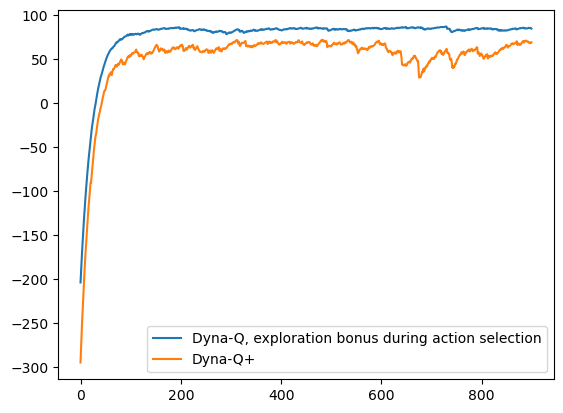

In [4]:
agent1_tr = np.zeros_like(agent1.ep_returns)
agent1_tr[0] = agent1.ep_returns[0]

step_size = 1 / (num_episodes // 40)
for i in range(1, len(agent1.ep_returns)):
    agent1_tr[i] = step_size * agent1.ep_returns[i] + (1 - step_size) * agent1_tr[i-1]

agent2_tr = np.zeros_like(agent2.ep_returns)
agent2_tr[0] = agent2.ep_returns[0]

for i in range(1, len(agent2.ep_returns)):
    agent2_tr[i] = step_size * agent2.ep_returns[i] + (1 - step_size) * agent2_tr[i-1]

start_from = 100
end_at = None
plt.plot(agent1_tr[start_from:end_at], label=f"Dyna-Q, exploration bonus during action selection")
plt.plot(agent2_tr[start_from:end_at], label=f"Dyna-Q+")
plt.legend()
plt.show()

### $Exercise\ \mathcal{8.5}$

#### How might the tabular Dyna-Q algorithm shown on page 164 be modified to handle stochastic environments? How might this modification perform poorly on changing environments such as considered in this section? How could the algorithm be modified to handle stochastic environments and changing environments?

Instead of storing the last experienced transition in the model, it could use the experienced transitions to calculate the sample average over possible transitions. This would perform poorly on changing environments, as the true sample average will then always be biased towards previous dynamics. One way to counteract this is to not use a true sample average, but to weight more recent transitions more highly than older ones.